In [3]:
import pandas_datareader as pdr
gs10 = pdr.get_data_fred('GS10')
gs10.head()

,GS10
DATE,
2019-08-01,1.63
2019-09-01,1.70
2019-10-01,1.71
2019-11-01,1.81
2019-12-01,1.86


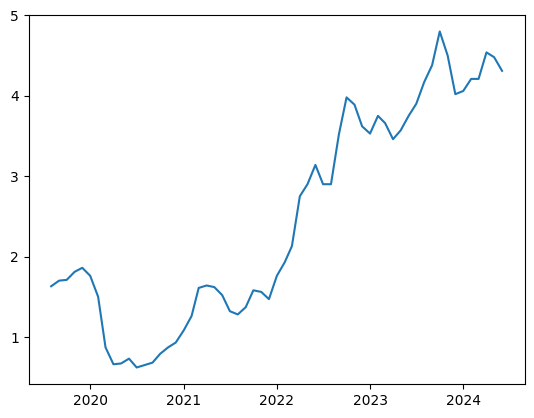

In [6]:
import matplotlib.pyplot as plt
plt.plot(gs10)

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset

num = len(gs10)  # 总数据量
x = torch.tensor(gs10['GS10'].to_list())  # 转为张量
seq_len = 6  # 预测序列长度
batch_size = 4  # 设置批大小

X_feature = torch.zeros((num - seq_len, seq_len))  # 全零初始化特征矩阵，num-seq_len行，seq_len列
for i in range(seq_len):
    X_feature[:, i] = x[i: num - seq_len + i]  # 为特征矩阵赋值
y_label = x[seq_len:].reshape((-1, 1))  # 真实结果列表

train_loader = DataLoader(TensorDataset(X_feature[:num-seq_len],
                          y_label[:num-seq_len]), batch_size=batch_size, shuffle=True)  # 构建数据加载器

In [12]:
len(train_loader.dataset)

53

In [13]:
train_loader.dataset[:batch_size]

(tensor([[1.6300, 1.7000, 1.7100, 1.8100, 1.8600, 1.7600],
         [1.7000, 1.7100, 1.8100, 1.8600, 1.7600, 1.5000],
         [1.7100, 1.8100, 1.8600, 1.7600, 1.5000, 0.8700],
         [1.8100, 1.8600, 1.7600, 1.5000, 0.8700, 0.6600]]),
 tensor([[1.5000],
         [0.8700],
         [0.6600],
         [0.6700]]))

In [17]:
from torch import nn
from tqdm import *

class Model(nn.Module):
    def __init__(self, input_size, output_size, num_hiddens):
        super().__init__()
        self.linear1 = nn.Linear(input_size, num_hiddens)
        self.linear2 = nn.Linear(num_hiddens, output_size)
    
    def forward(self, X):
        output = torch.relu(self.linear1(X))
        output = self.linear2(output)
        return output

# 定义超参数
input_size = seq_len
output_size = 1
num_hiddens = 10
lr = 0.01

# 建立模型
model = Model(input_size, output_size, num_hiddens)
criterion = nn.MSELoss(reduction='none')
trainer = torch.optim.Adam(model.parameters(), lr)

 70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 14/20 [00:00<00:00, 70.58it/s]

Epoch 1: Validation loss = 1.7193
Epoch 2: Validation loss = 0.4330
Epoch 3: Validation loss = 0.2658
Epoch 4: Validation loss = 0.2725
Epoch 5: Validation loss = 0.2666
Epoch 6: Validation loss = 0.2459
Epoch 7: Validation loss = 0.2463
Epoch 8: Validation loss = 0.2361
Epoch 9: Validation loss = 0.2647
Epoch 10: Validation loss = 0.2224
Epoch 11: Validation loss = 0.2172
Epoch 12: Validation loss = 0.2137
Epoch 13: Validation loss = 0.2371
Epoch 14: Validation loss = 0.2099
Epoch 15: Validation loss = 0.1968
Epoch 16: Validation loss = 0.1995


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 72.68it/s]

Epoch 17: Validation loss = 0.2150
Epoch 18: Validation loss = 0.2080
Epoch 19: Validation loss = 0.2306
Epoch 20: Validation loss = 0.1890


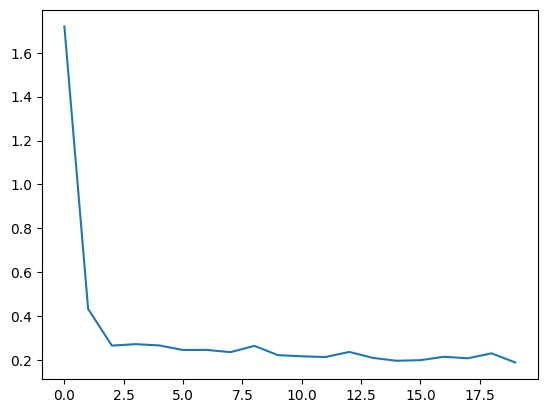

In [18]:
num_epochs = 20
loss_history = []

for epoch in tqdm(range(num_epochs)):
    # 批量训练
    for X, y in train_loader:
        trainer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.sum().backward()
        trainer.step()
    
    # 输出损失
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for X, y in train_loader:
            y_pred = model(X)
            loss = criterion(y_pred, y)
            total_loss += loss.sum() / loss.numel()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}: Validation loss = {avg_loss:.4f}')
        loss_history.append(avg_loss)

# 绘制损失函数随时间的曲线图
import matplotlib.pyplot as plt
plt.plot(loss_history, label='loss')

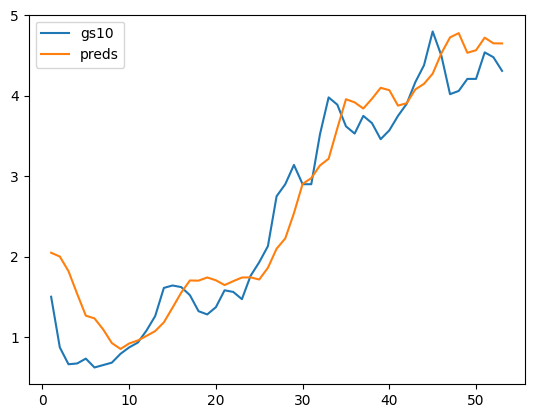

In [19]:
preds = model(X_feature)
time = torch.arange(1, num+1, dtype=torch.float32)  # 时间轴

plt.plot(time[:num-seq_len], gs10['GS10'].to_list()[seq_len:num], label='gs10')
plt.plot(time[:num-seq_len], preds.detach().numpy(), label='preds')
plt.legend()
plt.show()

In [20]:
import torch
from torch.utils.data import DataLoader, TensorDataset

num = len(gs10)  # 总数据量, 59
x = torch.tensor(gs10['GS10'].to_list())  # 股价列表
seq_len = 6  # 预测序列长度
batch_size = 4  # 设置批大小

X_feature = torch.zeros((num - seq_len, seq_len))  # 构建特征矩阵, num-seq_len行, seq_len列, 初始值均为0
Y_label = torch.zeros((num - seq_len, seq_len))  # 构建标签矩阵, 形状同特征矩阵
for i in range(seq_len):
    X_feature[:, i] = x[i: num - seq_len + i]  # 为特征矩阵赋值
    Y_label[:, i] = x[i+1: num - seq_len + i + 1]  # 为标签矩阵赋值

train_loader = DataLoader(TensorDataset(
    X_feature[:num-seq_len].unsqueeze(2), Y_label[:num-seq_len]),
    batch_size=batch_size, shuffle=True)  # 构建数据加载器

train_loader.dataset[:batch_size]

(tensor([[[1.6300],
          [1.7000],
          [1.7100],
          [1.8100],
          [1.8600],
          [1.7600]],
 
         [[1.7000],
          [1.7100],
          [1.8100],
          [1.8600],
          [1.7600],
          [1.5000]],
 
         [[1.7100],
          [1.8100],
          [1.8600],
          [1.7600],
          [1.5000],
          [0.8700]],
 
         [[1.8100],
          [1.8600],
          [1.7600],
          [1.5000],
          [0.8700],
          [0.6600]]]),
 tensor([[1.7000, 1.7100, 1.8100, 1.8600, 1.7600, 1.5000],
         [1.7100, 1.8100, 1.8600, 1.7600, 1.5000, 0.8700],
         [1.8100, 1.8600, 1.7600, 1.5000, 0.8700, 0.6600],
         [1.8600, 1.7600, 1.5000, 0.8700, 0.6600, 0.6700]]))

In [21]:
from torch import nn
from tqdm import *

class RNNModel(nn.Module):
    def __init__(self, input_size, output_size, num_hiddens, n_layers):
        super(RNNModel, self).__init__()
        self.num_hiddens = num_hiddens
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, num_hiddens, n_layers, batch_first=True)
        self.linear = nn.Linear(num_hiddens, output_size)

    def forward(self, X):
        batch_size = X.size(0)
        state = self.begin_state(batch_size)
        output, state = self.rnn(X, state)
        output = self.linear(torch.relu(output))
        return output, state

    def begin_state(self, batch_size=1):
        return torch.zeros(self.n_layers, batch_size, self.num_hiddens)

# 定义超参数
input_size = 1
output_size = 1
num_hiddens = 10
n_layers = 1
lr = 0.01

In [23]:
model = RNNModel(input_size, output_size, num_hiddens, n_layers)
criterion = nn.MSELoss(reduction='none')
trainer = torch.optim.Adam(model.parameters(), lr)

 45%|██████████████████████████████████████████████████▊                                                              | 9/20 [00:00<00:00, 41.30it/s]

Epoch 1: Validation loss = 2.8780
Epoch 2: Validation loss = 1.6986
Epoch 3: Validation loss = 1.5612
Epoch 4: Validation loss = 1.2076
Epoch 5: Validation loss = 0.7523
Epoch 6: Validation loss = 0.5643
Epoch 7: Validation loss = 0.3330
Epoch 8: Validation loss = 0.2370
Epoch 9: Validation loss = 0.1582


 70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 14/20 [00:00<00:00, 35.00it/s]

Epoch 10: Validation loss = 0.1118
Epoch 11: Validation loss = 0.0874
Epoch 12: Validation loss = 0.0780
Epoch 13: Validation loss = 0.0919
Epoch 14: Validation loss = 0.0646
Epoch 15: Validation loss = 0.0525
Epoch 16: Validation loss = 0.0524


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 38.22it/s]


Epoch 17: Validation loss = 0.0566
Epoch 18: Validation loss = 0.0496
Epoch 19: Validation loss = 0.0556
Epoch 20: Validation loss = 0.0599


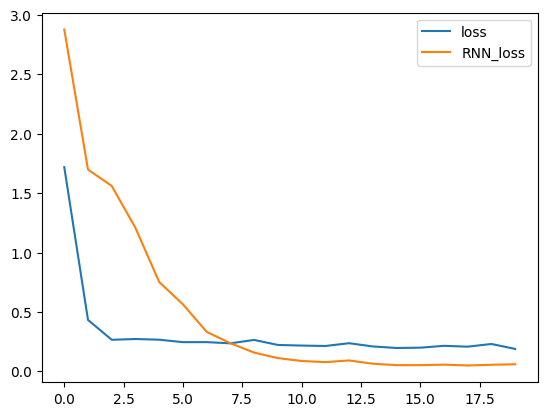

In [25]:
num_epochs = 20
rnn_loss_history = []

for epoch in tqdm(range(num_epochs)):
    # 批量训练
    for X, Y in train_loader:
        trainer.zero_grad()
        y_pred, state = model(X)
        loss = criterion(y_pred.squeeze(), Y.squeeze())
        loss.sum().backward()
        trainer.step()
    
    # 输出损失
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for X, Y in train_loader:
            y_pred, state = model(X)
            loss = criterion(y_pred.squeeze(), Y.squeeze())
            total_loss += loss.sum() / loss.numel()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}: Validation loss = {avg_loss:.4f}')
        rnn_loss_history.append(avg_loss)

# 绘制损失曲线图
import matplotlib.pyplot as plt
plt.plot(loss_history, label='loss')
plt.plot(rnn_loss_history, label='RNN_loss')
plt.legend()

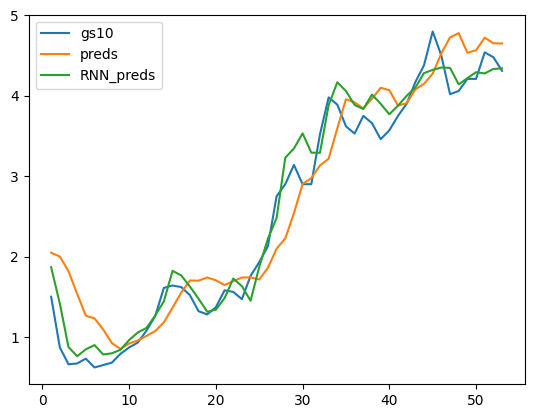

In [26]:
rnn_preds, _ = model(X_feature.unsqueeze(2))
preds.squeeze()
time = torch.arange(1, num+1, dtype=torch.float32)  # 时间轴

plt.plot(time[:num-seq_len], gs10['GS10'].to_list()[seq_len:num], label='gs10')
plt.plot(time[:num-seq_len], preds.detach().numpy(), label='preds')
plt.plot(time[:num-seq_len], rnn_preds[:, seq_len-1].detach().numpy(), label='RNN_preds')
plt.legend()
plt.show()